# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# Testing multilabel algorithms
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

### Referencias:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Montando Google Drive


In [1]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = 'drive/MyDrive/TesisMV'
except:
    root_dir = '..'
    
import os

## Selección de dataset y modelos

In [15]:
#modify only this cell
USE_RN50 = False
SUBCHAPTERS = False
ARCHITECTURE = 'resnet' 
DS_FLAGS = [] 
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
GAUSBLUR_TIMES = 1
NUM_LABELS = 26
K = 4

In [16]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
         'gausblur': GAUSBLUR_TIMES
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = MAP_TIMES.keys()
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

subchapter_str = 'subchapters' if SUBCHAPTERS else ''
Kfolds = {}

for i in range(0, K):
    print("Fold ", i)
    if ARCHITECTURE == 'resnet':
        patterns_dir = os.path.join(root_dir, 'patterns', subchapter_str + data_flags, str(i))
        labels_dir = os.path.join(root_dir, 'labels', subchapter_str + data_flags, str(i))
        exp_name = f'resnet50_K{i}' if USE_RN50 else f'resnet18_K{i}'
        rn = 50 if USE_RN50 else 18
        features_dir = os.path.join(root_dir, 'features', ARCHITECTURE, subchapter_str + data_flags, exp_name)
    
    else:
        patterns_dir = os.path.join(root_dir, 'patterns', subchapter_str + data_flags, str(i))
        labels_dir = os.path.join(root_dir, 'labels', subchapter_str + data_flags, str(i))
        exp_name = f'K{i}'
        features_dir = os.path.join(root_dir, 'features', ARCHITECTURE, subchapter_str + data_flags, exp_name)
    
    if not (os.path.isdir(patterns_dir) and os.path.isdir(labels_dir)):
        print(patterns_dir)
        print(labels_dir)
        raise FileNotFoundError("""
        No existen directorios de datos para el conjunto de flags seleccionado. 
        Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation.
        """)
    if not (os.path.isdir(features_dir)):
        print(features_dir)
        raise FileNotFoundError(f"""
        No se encontraron features para el conjunto de flags seleccionado. 
        Verifique que existan y, de lo contrario, llame a Feature Extraction
        """)
                                
    Kfolds[i] = {
        'patterns_dir': patterns_dir,
        'labels_dir': labels_dir,
        'features_dir': features_dir
    }
    
    print("--Pattern set encontrado en {}".format(patterns_dir))
    print("--Labels set encontrado en {}".format(labels_dir))
    print("--Features set encontrado en {}".format(features_dir))
    print("")

#../features/resnet/resnet50_base/
#../labels/base/
#Features set encontrado en ../features/resnet/resnet50_base/
#Labels set encontrado en ../labels/base/

Fold  0
--Pattern set encontrado en ..\patterns\base\0
--Labels set encontrado en ..\labels\base\0
--Features set encontrado en ..\features\resnet\base\resnet18_K0

Fold  1
--Pattern set encontrado en ..\patterns\base\1
--Labels set encontrado en ..\labels\base\1
--Features set encontrado en ..\features\resnet\base\resnet18_K1

Fold  2
--Pattern set encontrado en ..\patterns\base\2
--Labels set encontrado en ..\labels\base\2
--Features set encontrado en ..\features\resnet\base\resnet18_K2

Fold  3
--Pattern set encontrado en ..\patterns\base\3
--Labels set encontrado en ..\labels\base\3
--Features set encontrado en ..\features\resnet\base\resnet18_K3



In [17]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [18]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
import pickle

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Embedding classifiers
#from skmultilearn.embedding import OpenNetworkEmbedder, CLEMS, SKLearnEmbedder
#from sklearn.manifold import SpectralEmbedding
#from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
#from skmultilearn.embedding import EmbeddingClassifier
#from sklearn.ensemble import RandomForestRegressor

from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter

# Procesamiento

In [19]:
print("Iniciando revisión de datasets")
for i in range(0, K):
    fold = Kfolds[i]
    print("Fold ", i)
    features_dir = fold['features_dir']
    labels_dir = fold['labels_dir']

    features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
    features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
    features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')

    assert features_train.shape[1] == features_test.shape[1] == features_val.shape[1]
    assert features_test.shape[0] == 194
    assert features_val.shape[0] == 78
    print(f"--Utilizando descriptores de dimensión {features_train.shape[1]}")

    labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
    labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
    labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

    assert labels_train.shape[1] == labels_test.shape[1] == labels_val.shape[1]
    #assert labels_test.shape[0] == 194
    #assert labels_val.shape[0] == 78
    print(f"--Los archivos de etiquetas contienen {labels_train.shape[1]} etiquetas distintas.")
    print("Fold aprobado.")
    print()

Iniciando revisión de datasets
Fold  0
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  1
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  2
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  3
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.



# Data exploration

In [20]:
k = 1 # cambiar para explorar otros folds
print(f"Explorando fold {k}")
fold = Kfolds[k]
labels_dir = fold['labels_dir']
labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

train_columns = labels_train.columns.values
labels_75f = labels_train.loc[['75f']].values
print('Etiquetas 75f: ' + ''.join(np.where(labels_75f == 1, train_columns, '')[0]))

explorer = DataExplorer(labels_train, labels_val, labels_test)
combinations = explorer.get_unique_combinations(study='all')
metrics = explorer.get_label_metrics(study='all')

Explorando fold 1
Etiquetas 75f: horizontalpanelconcentriccircle
Number of unique labels combinations in all: 587
Label cardinality in all: 5.314432989690745
Label density in all: 0.01610434239300226


In [21]:
pruner = KunischPruner(NUM_LABELS)
print("Comenzando con i={}".format(NUM_LABELS))

# Carga o generacion de top labels
top_labels = None
if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle')):
    save = input(f"Se creará un archivo nuevo para {NUM_LABELS} labels con el fold 0. Desea continuar? (y/n)")
    if save == "y":
        labels_dir = Kfolds[0]['labels_dir']
        train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')
        top_labels = pruner.filter_labels(train_labels)
        with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'wb') as f:
            pickle.dump(top_labels, f)
        print("Top labels creado con éxito")
    else:
        raise Exception("No se logró cargar top_labels")
else:
    print(f"Usando top_labels previamente generados para {NUM_LABELS} labels")
    with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'rb') as f:
        top_labels = pickle.load(f)
    print(f"top labels previamente generado contiene {len(top_labels)} etiquetas")

pruner.set_top_labels(top_labels)

labels_train = pruner.filter_df(labels_train)
labels_val = pruner.filter_df(labels_val)
labels_test = pruner.filter_df(labels_test)
df = pd.concat([labels_train, labels_val, labels_test])

n = 1
#print(np.where((df.sum(axis=0) >= n)))
patrones = df.shape[0]
patrones_con_etiqueta = len(np.where((df.sum(axis=1) >= n))[0])
#print(np.where((df.sum(axis=1) >= n)))
print(patrones)
print(patrones_con_etiqueta)
print(patrones_con_etiqueta/patrones*100)
df = df.loc[df.sum(axis=1) >= n]

Comenzando con i=26
Usando top_labels previamente generados para 26 labels
top labels previamente generado contiene 26 etiquetas
776
759
97.80927835051546


In [24]:
explorer = DataExplorer(labels_train, labels_val, labels_test)
combinations = explorer.get_unique_combinations(study='all')
metrics = explorer.get_label_metrics(study='all')
print()
print("Mostrando ahora resultados para original df")
labels_original = pd.read_json("../labels/original_df.json", orient='index')
explorer = DataExplorer(labels_original, labels_original, labels_original)
combinations = explorer.get_unique_combinations(study='train')
metrics = explorer.get_label_metrics(study='train')


Number of unique labels combinations in all: 322
Label cardinality in all: 3.3853092783505048
Label density in all: 0.13020420301348096

Mostrando ahora resultados para original df
Number of unique labels combinations in train: 596
Label cardinality in train: 3.0309278350515365
Label density in train: 0.005172231800429243


# Funciones auxiliares

In [8]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    return clf_predictions

# Benchmark


In [115]:
TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"BRkNN": brknna, "MLkNN": mlknn, "MLTSVM": mltsvm}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'), "SVC": svm.SVC(), 
                    "DT": tree.DecisionTreeClassifier(), "GNB": GaussianNB()}

In [117]:
#LABELS_IN_STUDY = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
LABELS_IN_STUDY = [26]
#for i in range(26, 300, 10):
#    LABELS_IN_STUDY.append(i)

exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}
exp_f1 = {}
exp_precision = {}
exp_recall = {}
exp_acc = {}
exp_1mr = {}
exp_2mr = {}
exp_3mr = {}
exp_4mr = {}
exp_5mr = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss[meth_name + "_" + base_name] = []
    exp_f1[meth_name + "_" + base_name] = []
    exp_precision[meth_name + "_" + base_name] = []
    exp_recall[meth_name + "_" + base_name] = []
    exp_acc[meth_name + "_" + base_name] = []
    exp_1mr[meth_name + "_" + base_name] = []
    exp_2mr[meth_name + "_" + base_name] = []
    exp_3mr[meth_name + "_" + base_name] = []
    exp_4mr[meth_name + "_" + base_name] = []
    exp_5mr[meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss[meth_name] = []
  exp_f1[meth_name] = []
  exp_precision[meth_name] = []
  exp_recall[meth_name] = []
  exp_acc[meth_name] = []
  exp_1mr[meth_name] = []
  exp_2mr[meth_name] = []
  exp_3mr[meth_name] = []
  exp_4mr[meth_name] = []
  exp_5mr[meth_name] = []

PREVIOUS_LABELS = 0
USED_FREQS = []

output_dir = os.path.join(root_dir, 'outputs', ARCHITECTURE, 
                           subchapter_str + data_flags, f'{min(LABELS_IN_STUDY)}-{max(LABELS_IN_STUDY)}L')

os.makedirs(output_dir, exist_ok = True)

for i in LABELS_IN_STUDY:
  pruner = KunischPruner(i)
  print("Comenzando con i={}".format(i))
    
  # Carga o generacion de top labels
  top_labels = None
  if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{i}L.pickle')):
        save = input(f"Se creará un archivo nuevo para {i} labels con el fold 0. Desea continuar? (y/n)")
        if save == "y":
            labels_dir = Kfolds[0]['labels_dir']
            train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')
            top_labels = pruner.filter_labels(train_labels)
            with open(os.path.join(root_dir, 'labels', f'top_{i}L.pickle'), 'wb') as f:
                pickle.dump(top_labels, f)
            print("Top labels creado con éxito")
        else:
            raise Exception("No se logró cargar top_labels")
  else:
        print(f"Usando top_labels previamente generados para {i} labels")
        with open(os.path.join(root_dir, 'labels', f'top_{i}L.pickle'), 'rb') as f:
            top_labels = pickle.load(f)
        print(f"top labels previamente generado contiene {len(top_labels)} etiquetas")
  
  pruner.set_top_labels(top_labels)
        
  if len(top_labels) == PREVIOUS_LABELS:
        print(f"Al intentar usar {i} labels, se repitió el valor previo {PREVIOUS_LABELS}. Saltando iteración.")
        continue
        
  PREVIOUS_LABELS = len(top_labels)
  USED_FREQS.append(i)
  

  for meth_name, method in ADAPT_METHODS.items():
        print("-Probando suerte con", meth_name)

        sum_f1 = 0
        sum_recall = 0
        sum_precision = 0
        sum_acc = 0
        sum_hl = 0
        sum_emr = 0
        sum_hs = 0
        
        sum_mr1 = 0
        sum_mr2 = 0
        sum_mr3 = 0
        sum_mr4 = 0
        sum_mr5 = 0

        # Iterate over folds
        for j in range(0, K):
            #print(f"--Trabajando fold {j}")
            fold = Kfolds[j]
            features_dir = fold['features_dir']
            labels_dir = fold['labels_dir']
            
            features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
            features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
            features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
            
            labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
            labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
            labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')
            
            features_test = pd.concat([features_val, features_test])
            labels_test = pd.concat([labels_val, labels_test])
            
            # Dataset creation
            
            X_train = features_train.sort_index()
            X_test = features_test.sort_index()
            
            Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
            Y_test = pruner.filter_df(labels_test) # in both train and test

            Y_train = Y_train.sort_index()
            Y_test = Y_test.sort_index()
                
            assert X_train.index.all() == Y_train.index.all()
            assert X_test.index.all() == Y_test.index.all()              
            
            predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
            metrics = KunischMetrics(Y_test.values, predictions_i)
            
            micro_f1 = metrics.f1(average='micro')
            micro_recall = metrics.recall(average='micro')
            micro_precision = metrics.precision(average='micro')
            acc = metrics.acc()
            hl = metrics.hl()
            emr = metrics.emr()
            hs = metrics.hs()
            
            mr1 = metrics.mr1()
            mr2 = metrics.mr2()
            mr3 = metrics.mr3()
            mr4 = metrics.mr4()
            mr5 = metrics.mr5()

            #print("---Micro F1:", micro_f1)
            #print("---Micro recall:", micro_recall)
            #print("---Micro precision:", micro_precision)
            #print("---Accuracy:", acc)
            #print("---Hamming Loss:", hl)
            #print("---Exact Match Ratio:", emr)
            #print("---Hamming Score:", hs)
            #print("---5-Match Ratio:", mr5)

            sum_f1 += micro_f1
            sum_recall += micro_recall
            sum_precision += micro_precision
            sum_acc += acc
            sum_hl += hl 
            sum_emr += emr
            sum_hs += hs
            
            sum_mr1 += mr1
            sum_mr2 += mr2
            sum_mr3 += mr3
            sum_mr4 += mr4
            sum_mr5 += mr5
            #print("")

        avg_f1 = round(sum_f1/K, 4)
        avg_recall = round(sum_recall/K, 4)
        avg_precision = round(sum_precision/K, 4)
        avg_acc = round(sum_acc/K, 4)
        avg_hl = round(sum_hl/K, 4)
        avg_emr = round(sum_emr/K, 4)
        avg_hs = round(sum_hs/K, 4)
        
        avg_mr1 = round(sum_mr1/K, 4)
        avg_mr2 = round(sum_mr2/K, 4)
        avg_mr3 = round(sum_mr3/K, 4)
        avg_mr4 = round(sum_mr4/K, 4)
        avg_mr5 = round(sum_mr5/K, 4)
        
        print("---AVG Micro F1:", avg_f1)
        print("---AVG Micro recall:", avg_recall)
        print("---AVG Micro precision:", avg_precision)
        print("---AVG Accuracy:", avg_acc)
        print("---AVG Hamming Loss:", avg_hl)
        print("---AVG Exact Match Ratio:", avg_emr)
        print("---AVG Hamming Score:", avg_hs)
        print("---AVG 1-Match Ratio:", avg_mr1)
        print("---AVG 2-Match Ratio:", avg_mr2)
        print("---AVG 3-Match Ratio:", avg_mr3)
        print("---AVG 4-Match Ratio:", avg_mr4)
        print("---AVG 5-Match Ratio:", avg_mr5)
            
        exp_exact_match[meth_name].append(avg_emr)
        exp_hscore[meth_name].append(avg_hs)
        exp_hloss[meth_name].append(avg_hl)
        exp_precision[meth_name].append(avg_precision)
        exp_recall[meth_name].append(avg_recall)
        exp_f1[meth_name].append(avg_f1)
        exp_acc[meth_name].append(avg_acc)
        
        exp_1mr[meth_name].append(avg_mr1)
        exp_2mr[meth_name].append(avg_mr2)
        exp_3mr[meth_name].append(avg_mr3)
        exp_4mr[meth_name].append(avg_mr4)
        exp_5mr[meth_name].append(avg_mr5)
        
        print("")
        
  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
        for base_name, classifier in BASE_CLASSIFIERS.items():
            print("-Probando suerte con", meth_name, base_name)

            sum_f1 = 0
            sum_recall = 0
            sum_precision = 0
            sum_acc = 0
            sum_hl = 0
            sum_emr = 0
            sum_hs = 0
            
            sum_mr1 = 0
            sum_mr2 = 0
            sum_mr3 = 0
            sum_mr4 = 0
            sum_mr5 = 0

            # Iterate over folds
            for j in range(0, K):
                #print(f"--Trabajando fold {i}")
                fold = Kfolds[j]
                features_dir = fold['features_dir']
                labels_dir = fold['labels_dir']
                features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
                features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
                features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
                labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
                labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
                labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')
                
                # Dataset creation
                X_train = features_train.sort_index()
                X_test = features_test.sort_index()
                
                Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
                Y_test = pruner.filter_df(labels_test) # in both train and test
                
                Y_train = Y_train.sort_index()
                Y_test = Y_test.sort_index()
                
                assert X_train.index.all() == Y_train.index.all()
                assert X_test.index.all() == Y_test.index.all()
                
                predictions_i = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
                metrics = KunischMetrics(Y_test.values, predictions_i)

                micro_f1 = metrics.f1(average='micro')
                micro_recall = metrics.recall(average='micro')
                micro_precision = metrics.precision(average='micro')
                acc = metrics.acc()
                hl = metrics.hl()
                emr = metrics.emr()
                hs = metrics.hs()
                
                mr1 = metrics.mr1()
                mr2 = metrics.mr2()
                mr3 = metrics.mr3()
                mr4 = metrics.mr4()
                mr5 = metrics.mr5()
                #print("---Micro F1:", micro_f1)
                #print("---Micro recall:", micro_recall)
                #print("---Micro precision:", micro_precision)
                #print("---Accuracy:", acc)
                #print("---Hamming Loss:", hl)
                #print("---Exact Match Ratio:", emr)
                #print("---Hamming Score:", hs)
                #print("---5-Match Ratio:", mr5)

                sum_f1 += micro_f1
                sum_recall += micro_recall
                sum_precision += micro_precision
                sum_acc += acc
                sum_hl += hl 
                sum_emr += emr
                sum_hs += hs
                
                sum_mr1 += mr1
                sum_mr2 += mr2
                sum_mr3 += mr3
                sum_mr4 += mr4
                sum_mr5 += mr5
                #print("")

            avg_f1 = round(sum_f1/K, 4)
            avg_recall = round(sum_recall/K, 4)
            avg_precision = round(sum_precision/K, 4)
            avg_acc = round(sum_acc/K, 4)
            avg_hl = round(sum_hl/K, 4)
            avg_emr = round(sum_emr/K, 4)
            avg_hs = round(sum_hs/K, 4)
            
            avg_mr1 = round(sum_mr1/K, 4)
            avg_mr2 = round(sum_mr2/K, 4)
            avg_mr3 = round(sum_mr3/K, 4)
            avg_mr4 = round(sum_mr4/K, 4)
            avg_mr5 = round(sum_mr5/K, 4)

            print("---AVG Micro F1:", avg_f1)
            print("---AVG Micro recall:", avg_recall)
            print("---AVG Micro precision:", avg_precision)
            print("---AVG Accuracy:", avg_acc)
            print("---AVG Hamming Loss:", avg_hl)
            print("---AVG Exact Match Ratio:", avg_emr)
            print("---AVG Hamming Score:", avg_hs)
            print("---AVG 1-Match Ratio:", avg_mr1)
            print("---AVG 2-Match Ratio:", avg_mr2)
            print("---AVG 3-Match Ratio:", avg_mr3)
            print("---AVG 4-Match Ratio:", avg_mr4)
            print("---AVG 5-Match Ratio:", avg_mr5)

            exp_exact_match[meth_name + "_" + base_name].append(avg_emr)
            exp_hscore[meth_name + "_" + base_name].append(avg_hs)
            exp_hloss[meth_name + "_" + base_name].append(avg_hl)
            exp_precision[meth_name + "_" + base_name].append(avg_precision)
            exp_recall[meth_name + "_" + base_name].append(avg_recall)
            exp_f1[meth_name + "_" + base_name].append(avg_f1)
            exp_acc[meth_name + "_" + base_name].append(avg_acc)
            exp_1mr[meth_name + "_" + base_name].append(avg_mr1)
            exp_2mr[meth_name + "_" + base_name].append(avg_mr2)
            exp_3mr[meth_name + "_" + base_name].append(avg_mr3)
            exp_4mr[meth_name + "_" + base_name].append(avg_mr4)
            exp_5mr[meth_name + "_" + base_name].append(avg_mr5)
            print("")


Comenzando con i=26
Usando top_labels previamente generados para 26 labels
top labels previamente generado contiene 26 etiquetas
-Probando suerte con BRkNN
---AVG Micro F1: 0.4962
---AVG Micro recall: 0.4932
---AVG Micro precision: 0.4996
---AVG Accuracy: 0.1048
---AVG Hamming Loss: 0.1312
---AVG Exact Match Ratio: 0.1048
---AVG Hamming Score: 0.1254
---AVG 1-Match Ratio: 0.7298
---AVG 2-Match Ratio: 0.5377
---AVG 3-Match Ratio: 0.2353
---AVG 4-Match Ratio: 0.1324
---AVG 5-Match Ratio: 0.0294

-Probando suerte con MLkNN
---AVG Micro F1: 0.4962
---AVG Micro recall: 0.4932
---AVG Micro precision: 0.4996
---AVG Accuracy: 0.1048
---AVG Hamming Loss: 0.1312
---AVG Exact Match Ratio: 0.1048
---AVG Hamming Score: 0.1254
---AVG 1-Match Ratio: 0.7298
---AVG 2-Match Ratio: 0.5377
---AVG 3-Match Ratio: 0.2353
---AVG 4-Match Ratio: 0.1324
---AVG 5-Match Ratio: 0.0294

-Probando suerte con MLTSVM
---AVG Micro F1: 0.3082
---AVG Micro recall: 0.3422
---AVG Micro precision: 0.2811
---AVG Accuracy: 0.0

D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

---AVG Micro F1: 0.6039
---AVG Micro recall: 0.5306
---AVG Micro precision: 0.7012
---AVG Accuracy: 0.125
---AVG Hamming Loss: 0.0905
---AVG Exact Match Ratio: 0.125
---AVG Hamming Score: 0.1254
---AVG 1-Match Ratio: 0.8042
---AVG 2-Match Ratio: 0.6083
---AVG 3-Match Ratio: 0.2539
---AVG 4-Match Ratio: 0.1031
---AVG 5-Match Ratio: 0.0168

-Probando suerte con RakelD SVC


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

---AVG Micro F1: 0.4446
---AVG Micro recall: 0.3248
---AVG Micro precision: 0.7257
---AVG Accuracy: 0.0812
---AVG Hamming Loss: 0.1049
---AVG Exact Match Ratio: 0.0812
---AVG Hamming Score: 0.1201
---AVG 1-Match Ratio: 0.567
---AVG 2-Match Ratio: 0.3724
---AVG 3-Match Ratio: 0.116
---AVG 4-Match Ratio: 0.0361
---AVG 5-Match Ratio: 0.0065

-Probando suerte con RakelD DT


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

---AVG Micro F1: 0.4619
---AVG Micro recall: 0.4804
---AVG Micro precision: 0.4448
---AVG Accuracy: 0.0271
---AVG Hamming Loss: 0.1458
---AVG Exact Match Ratio: 0.0271
---AVG Hamming Score: 0.1231
---AVG 1-Match Ratio: 0.7951
---AVG 2-Match Ratio: 0.5051
---AVG 3-Match Ratio: 0.219
---AVG 4-Match Ratio: 0.0863
---AVG 5-Match Ratio: 0.0181

-Probando suerte con RakelD GNB


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

---AVG Micro F1: 0.3518
---AVG Micro recall: 0.6612
---AVG Micro precision: 0.2399
---AVG Accuracy: 0.0
---AVG Hamming Loss: 0.3164
---AVG Exact Match Ratio: 0.0
---AVG Hamming Score: 0.1222
---AVG 1-Match Ratio: 0.8905
---AVG 2-Match Ratio: 0.6907
---AVG 3-Match Ratio: 0.3982
---AVG 4-Match Ratio: 0.1765
---AVG 5-Match Ratio: 0.0618



In [120]:
df_output = {}
for meth_name in exp_exact_match.keys():
    meth_results = {
        'accuracy': exp_acc[meth_name][0],
        'hamming_score': exp_hscore[meth_name][0],
        'hamming_loss': exp_hloss[meth_name][0],
        'f1_score': exp_f1[meth_name][0],
        'recall': exp_recall[meth_name][0],
        'precision': exp_precision[meth_name][0],
        'emr': exp_exact_match[meth_name][0],
        '1mr': exp_1mr[meth_name][0],
        '2mr': exp_2mr[meth_name][0],
        '3mr': exp_3mr[meth_name][0],
        '4mr': exp_4mr[meth_name][0],
        '5mr': exp_5mr[meth_name][0],
    }
    df_output[meth_name] = meth_results
    
df_output = pd.DataFrame.from_dict(df_output, orient='index')
os.makedirs(output_dir, exist_ok=True)
df_output.to_csv(os.path.join(output_dir, 'resultados.csv'))

In [49]:
df_output

,accuracy,hamming_score,hamming_loss,f1_score,recall,precision,emr,1mr,2mr,3mr,4mr,5mr
BR_LR,0.1353,0.1273,0.0863,0.6064,0.5104,0.7476,0.1353,0.7745,0.5992,0.2268,0.0992,0.0180
BR_SVC,0.0773,0.1177,0.1033,0.4399,0.3120,0.7490,0.0773,0.5374,0.3595,0.1198,0.0374,0.0013
BR_DT,0.0361,0.1236,0.1452,0.4716,0.4972,0.4492,0.0361,0.7886,0.5335,0.2358,0.0953,0.0219
BR_GNB,0.0000,0.1222,0.4078,0.3173,0.7265,0.2032,0.0000,0.8995,0.7577,0.4742,0.2268,0.0735
LP_LR,0.1727,0.1280,0.1060,0.5686,0.5364,0.6051,0.1727,0.7513,0.6057,0.2668,0.1379,0.0322
LP_SVC,0.1121,0.1212,0.1278,0.4367,0.3812,0.5116,0.1121,0.6018,0.4601,0.1211,0.0709,0.0181
LP_DT,0.0953,0.1252,0.1426,0.4470,0.4427,0.4516,0.0953,0.6701,0.4678,0.2139,0.1108,0.0232
LP_GNB,0.0966,0.1209,0.1315,0.4530,0.4187,0.4939,0.0966,0.6482,0.4575,0.1933,0.0851,0.0181
CC_LR,0.1624,0.1250,0.0860,0.6171,0.5322,0.7348,0.1624,0.7758,0.6199,0.2474,0.1224,0.0219
CC_SVC,0.0850,0.1148,0.1040,0.4325,0.3044,0.7497,0.0850,0.5090,0.3595,0.1211,0.0387,0.0013


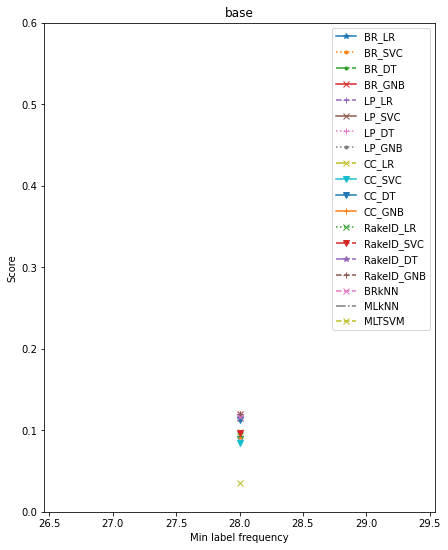

In [53]:
plotter = KunischPlotter()

plotter.plot_results(USED_FREQS,
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [61]:
top_labels

panel            266
horizontal       218
ornament         111
hatched          102
vertical          92
metopal           84
circle            77
filling           77
enclosing         63
lozenge           61
double            59
cross-hatched     51
triangle          45
concentric        41
dotted            36
outline           36
meander           35
solid             33
chain             33
bar               32
cross             31
line              29
dot               28
hook              25
swastika          22
floor             22
dtype: int64

In [62]:
print(data_flags)
for m, hl in zip(exp_exact_match.keys(), exp_hscore.values()):
    print(m, max(hl))

base
BR_LR 0.1273
BR_SVC 0.1177
BR_DT 0.1252
BR_GNB 0.1222
LP_LR 0.128
LP_SVC 0.1212
LP_DT 0.124
LP_GNB 0.1209
CC_LR 0.125
CC_SVC 0.1148
CC_DT 0.1205
CC_GNB 0.1222


ValueError: max() arg is an empty sequence

In [98]:
features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
    
labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

In [99]:
features_dir

'..\\features\\resnet\\base\\resnet18_K3'

In [100]:
labels_dir

'..\\labels\\base\\3'

In [101]:
features_train

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
27f,0.485242,0.752830,0.497157,0.022583,2.893077,0.168479,0.030343,0.050014,0.669086,0.256953,...,0.369268,0.326358,0.047360,0.344772,0.111287,0.884672,2.545797,0.008964,0.097239,0.016189
18h,0.730451,0.499935,0.482342,0.008889,3.450725,0.203110,0.018493,0.019662,0.237251,0.193216,...,0.273765,0.107704,0.013119,0.079985,0.019158,0.572859,3.575332,0.005917,0.040937,0.017329
23c,0.658249,1.007370,0.696468,0.012934,3.649672,0.132876,0.039003,0.009493,0.543790,0.162926,...,0.447222,0.113304,0.031971,0.021210,0.118054,0.684350,2.541629,0.056772,0.008230,0.058662
1l,0.785904,0.755667,0.176404,0.199597,0.950361,0.008888,0.014962,0.295140,1.154338,0.714935,...,0.560218,0.870320,0.128375,0.778161,0.376835,1.141749,0.466888,0.014584,0.585304,0.016157
41c,0.757004,0.826151,0.089773,0.650969,0.120826,0.256639,0.516171,1.392757,1.077512,1.294155,...,0.783816,0.963241,0.298135,0.635758,0.464225,0.855955,0.160040,1.047293,0.192822,0.376610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62f,0.476526,0.598545,0.009654,0.195934,0.079301,0.001118,0.103690,0.053752,1.445787,0.556255,...,0.568778,1.564268,0.111355,1.699113,0.072128,1.580315,0.092647,0.027331,0.212844,0.009282
38e,0.842689,0.755669,0.012148,0.411598,0.057198,0.109640,0.558683,0.936755,0.749485,1.041867,...,0.915081,1.084292,0.057983,1.310053,0.446216,0.987619,0.075484,0.725789,0.192956,0.171052
86b,0.324612,0.441211,2.173295,1.567119,0.391439,1.167604,1.290307,1.330870,0.576396,0.585445,...,0.360599,0.468669,1.710467,0.503278,1.878701,0.413735,0.848630,0.790961,1.896611,1.478192
9c,0.503765,0.753490,0.807084,0.657278,0.446944,0.138285,0.144803,0.334821,0.792854,0.534080,...,0.636944,0.749536,0.428479,0.907983,0.540830,0.608013,0.202008,0.203345,0.600078,0.364608


In [102]:
labels_train

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
44l,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66f,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18g,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95c,0,0,1,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96f,0,0,0,1,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
78g,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
85a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14a,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
labels_train.index

Index(['44l', '66f', '18g', '8c', '95c', '14b', '23e', '2h', '47g', '4c',
       ...
       '59e', '77k', '58b', '59b', '53e', '96f', '78g', '85a', '14a', '9d'],
      dtype='object', length=504)

In [104]:
features_train.index

Index(['27f', '18h', '23c', '1l', '41c', '89b', '44f', '90a', '53b', '58d',
       ...
       '84f', '55b', '36e', '67m', '78c', '62f', '38e', '86b', '9c', '46k'],
      dtype='object', length=504)

In [105]:
labels_test.index

Index(['44c', '86d', '11k', '47k', '78m', '87d', '95f', '66h', '65b', '62a',
       ...
       '96c', '78a', '84b', '69c', '63c', '3c', '63g', '33d', '11g', '3f'],
      dtype='object', length=194)

In [106]:
features_test.index

Index(['33d', '47i', '9b', '60b', '33c', '1c', '28g', '93b', '74d', '21i',
       ...
       '23f', '69h', '91i', '75b', '55c', '54c', '66b', '58h', '88e', '76f'],
      dtype='object', length=194)

In [107]:
METHOD = "MLTSVM" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "LR" # | "SVC" | "DT" | "GNB" | "LR"
num_labels = 26

pruner = KunischPruner(num_labels)
top_labels = pruner.filter_labels(labels_train)
pruner.set_top_labels(top_labels)

print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
Y_train = pruner.filter_df(labels_train).sort_index()
X_train = features_train.sort_index()
Y_test = pruner.filter_df(labels_test).sort_index()
X_test = features_test.sort_index()


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

metrics = KunischMetrics(Y_test.values, predictions)

print("HAMMING SCORE: {}".format(metrics.hs()))
predictions = predictions
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

Aplicando threshold 24 para trabajar con 26 labels
ATTENTION: TESTING WITH 26 LABELS
HAMMING SCORE: 0.1554
               precision    recall  f1-score   support

        panel       0.91      0.44      0.59        73
   horizontal       0.93      0.37      0.53        99
     ornament       0.56      0.41      0.47        44
      hatched       0.21      0.62      0.31        13
     vertical       0.23      0.40      0.29        25
       circle       0.11      0.35      0.17        17
      metopal       0.31      0.15      0.20        33
      lozenge       1.00      0.02      0.04        44
      filling       0.05      0.08      0.06        13
       double       0.24      0.30      0.27        33
    enclosing       0.20      0.06      0.09        35
cross-hatched       0.28      0.47      0.35        17
     triangle       0.14      0.33      0.20        12
   concentric       0.16      0.47      0.24        17
       dotted       0.05      0.11      0.07         9
        chai

In [108]:
print(Y_test.shape)
print(predictions.shape)

(194, 26)
(194, 26)


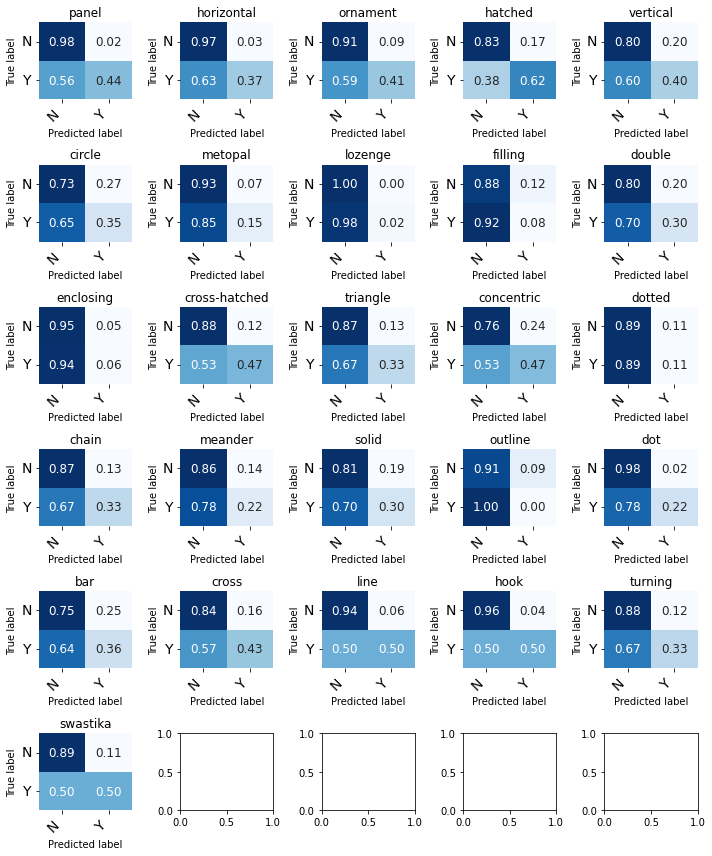

In [110]:
plotter = KunischPlotter()
plotter.plot_multiple_matrix(cfs_matrix, present_labels, nrows=6, ncols=5, figsize=(10,12), normalize=True)
#plot_multiple_matrix(cfs_matrix, present_labels, figsize=(10, 10))